In [ ]:
import os
import json
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as tvt
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, folder_path = '', label_path = '', transform = [tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]):

        self.folder_path = folder_path
        self.label_path = label_path
        self.files = os.listdir(self.folder_path)
        self.files.sort()
        self.labels = os.listdir(self.label_path)
        self.labels.sort()
        self.transform=transform


    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):


        image = Image.open(self.folder_path + '/' + self.files[index]).resize((512,512))

        label_image = Image.open(self.label_path + '/' + self.labels[index]).resize((512,512))
        #print(np.array(label_image))
        #print("image", image.size)
        #print("label", label_image.size)
        #print('label_image', np.array(label_image))

        tvt_form = tvt.Compose(self.transform)
        tensor_image = tvt_form(image)
        '''
        label_tensor_image = toTensor(label_image)
        label_tensor_image = label_tensor_image.long()'''
        label_tensor_image = torch.tensor(np.array(label_image), dtype= torch.long)


        #print("tensor", tensor_image.shape)
        #print("label tensor", label_tensor_image)

        return tensor_image, label_tensor_image

In [ ]:
class InitialBlock(nn.Module):
    def __init__(self, in_channels = int, out_channels = int):

        super(InitialBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels= self.in_channels,
                              out_channels =13,
                              kernel_size= 3,
                              stride = 2,
                              padding = 1,
                              bias = False
                              )
        self.pooling = nn.MaxPool2d(kernel_size=2, stride = 2)

    def forward(self, x):
        identity = x
        #print(identity.shape)
        x = self.conv(x)
        #print("conv", x.shape)
        pool = self.pooling(identity)
        #print("pool", pool.shape)
        concatenated_tensor = torch.cat((x, pool), dim = 1)
        #print(concatenated_tensor.shape)
        return concatenated_tensor

In [ ]:
class Bottleneck_1(nn.Module):

  def __init__(self, in_channels = int, out_channels = int,
              downsample = False, dilation = int, asymmetric = int, p = 0.01):

    super(Bottleneck_1,self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.dilation = dilation
    self.asymmetric = asymmetric
    self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)
    self.prelu = nn.PReLU()

    self.dropout = nn.Dropout2d(p = p)
    self.downsample = downsample
    if self.downsample is True:
      #In the original paper I think they reduce the dimensions(channels) in 2x2
      #Convolution too. Keeping this for now
      self.conv2x2 = nn.Conv2d(in_channels= self.in_channels,
                            out_channels= self.in_channels,
                            kernel_size= 2, stride= 2, bias=False)
      self.bn1 = nn.BatchNorm2d(self.in_channels)
      self.conv = nn.Conv2d(in_channels= self.in_channels,
                            out_channels=int(self.out_channels/2),
                            kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(int(self.out_channels/2))
      self.conv1x1_exp = nn.Conv2d(in_channels= int(self.out_channels/2),
                               out_channels= self.out_channels,
                               kernel_size= 1, bias=False)
      self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
      self.num_channels_pad = self.out_channels - self.in_channels


    if self.downsample is False:
      self.conv1x1 = nn.Conv2d(in_channels= self.in_channels,
                              out_channels= int(self.in_channels/2),
                              kernel_size= 1, stride=1, bias=False
                              )
      self.bn1 = nn.BatchNorm2d(int(self.in_channels/2))
      self.conv = nn.Conv2d(in_channels=int(self.in_channels/2),
                            out_channels = int(self.in_channels/2),
                            kernel_size= 3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(int(self.in_channels/2))
      self.conv1x1_exp  =nn.Conv2d(in_channels=int(self.in_channels/2),
                               out_channels= self.out_channels,
                               kernel_size=1, stride=1, bias=False)


  def forward(self, x):
    identity = x
    if self.downsample is True:
      x = self.conv2x2(x)
      x = self.bn1(x)
      x = self.prelu(x)
      x = self.conv(x)
      x = self.bn2(x)
      x = self.prelu(x)
      x = self.conv1x1_exp(x)
      x = self.dropout(x)
      identity = self.maxpool(identity)

      req_channels = x.shape[1] - identity.shape[1]
      #zeros tensor needs to be changed I guess. I dont see this is a right way to do it
      zeros = torch.zeros(identity.shape[0], req_channels,
                          identity.shape[2], identity.shape[3]).to('cuda')
      #identity = nn.functional.pad(identity, (0, self.num_channels_pad, 0, 0),"constant", 0)
      identity = torch.cat((identity, zeros), dim = 1)
      out = x + identity
      #print("out", out.shape)

    if self.downsample is False:
      #print(x.shape)
      x = self.conv1x1(x)
      x = self.bn1(x)
      x = self.prelu(x)
      x = self.conv(x)
      x = self.bn2(x)
      x = self.prelu(x)
      x = self.conv1x1_exp(x)
      x = self.dropout(x)
      out = x

    return out










In [ ]:
'''Update: Try to generalize for other values for asymmetric convolution
and not only 1x5,5x1'''

class Bottleneck_2(nn.Module):

  def __init__(self,in_channels:int, out_channels:int, dilation = 0,
               asymmetric = False, p = 0.1):

     super(Bottleneck_2,self).__init__()
     self.in_channels = in_channels
     self.out_channels = out_channels
     self.dilation = dilation
     self.asymmetric = asymmetric
     self.prelu = nn.PReLU()
     self.bn = nn.BatchNorm2d(int(self.out_channels/2))
     self.dropout = nn.Dropout2d(p=p)

     if asymmetric is True:
      self.conv1x1 = nn.Conv2d(in_channels= self.in_channels,
                              out_channels= int(self.out_channels/2),
                              kernel_size= 1, stride=1, bias=False
                              )

      self.conv5x1 = nn.Conv2d(in_channels= int(self.out_channels/2),
                            out_channels = int(self.out_channels/2),
                            kernel_size= (5,1), stride=1,
                               padding=(2,0), bias=False)
      self.conv1x5 = nn.Conv2d(in_channels= int(self.out_channels/2),
                            out_channels = int(self.out_channels/2),
                            kernel_size= (1, 5), stride=1,
                               padding=(0,2), bias=False)
      self.conv1x1_exp  =nn.Conv2d(in_channels=int(self.in_channels/2),
                               out_channels= self.out_channels,
                               kernel_size=1, stride=1, bias=False)
     if self.dilation != 0:
      self.conv1x1 = nn.Conv2d(in_channels= self.in_channels,
                              out_channels= int(self.out_channels/2),
                              kernel_size= 1, stride=1, bias=False
                              )
      padding = ((3 - 1) * self.dilation) // 2
      self.conv = nn.Conv2d(in_channels=int(self.out_channels/2),
                            out_channels = int(self.out_channels/2),
                            kernel_size= 3, stride=1, padding=padding,
                            dilation=self.dilation, bias=False)

      self.conv1x1_exp  =nn.Conv2d(in_channels=int(self.out_channels/2),
                               out_channels= self.out_channels,
                               kernel_size=1, stride=1, bias=False)
  def forward(self, x):

    if self.asymmetric is True:
      #print(x.shape)
      out = self.conv1x1(x)
      #print(out.shape)
      out = self.bn(out)
      out = self.prelu(out)
      out = self.conv5x1(out)
      #print(out.shape)
      out = self.bn(out)
      out = self.prelu(out)
      out = self.conv1x5(out)
      #print(out.shape)
      out = self.bn(out)
      out = self.prelu(out)
      out = self.conv1x1_exp(out)
      out = self.dropout(out)
      #print("asymmetric", out.shape)

    if self.dilation:
      #print(self.dilation)
      out = self.conv1x1(x)
      #print(out.shape)
      out = self.bn(out)
      out = self.prelu(out)
      out = self.conv(out)
      #print(out.shape)
      out = self.bn(out)
      out = self.prelu(out)
      out = self.conv1x1_exp(out)
      out = self.dropout(out)
      #print("dilation", out.shape)

    return out







In [ ]:
'''In Transpose Convolutions:
1. Larger the Kernel Size----> Larger the output image (if no padding is added).
2. Larger the strides, the larger the output matrix (if no padding).
3.  the padding parameter also can be the two strings: “valid” and “same”. However,
since we expand the input layer in transposed convolutions, if choosing “valid”,
the output shape will be larger than the input shape. If “same” is used, then the
output shape is forced to become the input shape multiplied by the stride. If this
output shape is smaller than the original output shape, then only the very middle
part of the output is maintained.


'''

class Bottleneck_Upsample(nn.Module):
  def __init__(self, in_channels = int, out_channels = int, upsample = False,
               p = 0.1):
    super(Bottleneck_Upsample,self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.prelu = nn.PReLU()
    self.upsample = upsample
    self.dropout = nn.Dropout2d(p=p)
    self.unpool = nn.MaxUnpool2d(kernel_size= 2, stride=2)
    self.conv_pad = nn.Conv2d(in_channels=self.in_channels,
                              out_channels=self.out_channels,
                              kernel_size=3, stride=1, padding=1, bias=False)

    if self.upsample is True:



      self.trans_conv1x1 = nn.ConvTranspose2d(in_channels=self.in_channels,
                                          out_channels= self.in_channels,
                                          kernel_size=1, stride=1, bias=False)
      self.bn1 = nn.BatchNorm2d(self.in_channels)
      self.tran_conv = nn.ConvTranspose2d(in_channels=self.in_channels,
                                          out_channels= self.out_channels,
                                          kernel_size=3, stride=2, padding=1,
                                          output_padding=1, bias= False)
      self.bn2 = nn.BatchNorm2d(self.out_channels)

      self.trans_conv1x1exp = nn.ConvTranspose2d(in_channels=self.out_channels,
                                          out_channels= self.out_channels,
                                          kernel_size=1, stride=1, bias=False)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1, return_indices=True)


    elif self.upsample is False:

      self.trans_conv1x1 = nn.ConvTranspose2d(in_channels=self.in_channels,
                                          out_channels= self.in_channels,
                                          kernel_size=1, stride=1, bias=False)
      self.bn1 = nn.BatchNorm2d(self.in_channels)
      self.tran_conv = nn.ConvTranspose2d(in_channels= self.in_channels,
                                          out_channels= self.out_channels,
                                          kernel_size=3, stride=1, padding=1,
                                          output_padding=0, bias=False)
      self.bn2 = nn.BatchNorm2d(self.out_channels)
      self.trans_conv1x1exp = nn.ConvTranspose2d(in_channels=self.out_channels,
                                          out_channels= self.out_channels,
                                          kernel_size=1, stride=1, bias=False)







  def forward(self, x):
    out = None
    x_copy = x
    if self.upsample is True:
      #print("upsampling")
      #print("x", x.shape)
      out = self.trans_conv1x1(x)
      out = self.bn1(out)
      out = self.prelu(out)
      out = self.tran_conv(out)
      out = self.bn2(out)
      out = self.prelu(out)
      out = self.trans_conv1x1exp(out)
      out = self.dropout(out)
      #print("out",out.shape)
      output, indices = self.maxpool(x_copy)
      identity = self.unpool(x_copy, indices)
      identity = self.conv_pad(identity)
      #print("identity after unpool and conv pad", identity.shape)
      out = identity + out
      #print("out after concat", out.shape)

    elif self.upsample is False:
      #print("Not Upsampling")
      out = self.trans_conv1x1(x)
      out = self.bn1(out)
      out = self.prelu(out)
      out = self.tran_conv(out)
      out = self.bn2(out)
      out = self.prelu(out)
      out = self.trans_conv1x1exp(out)
      out = self.dropout(out)





    #print(out.shape)
    return out










In [ ]:
class ENet(nn.Module):
  def __init__(self, num_classes = int):

    super(ENet, self).__init__()
    if num_classes is None:
      self.num_classes = 3
    else:
      self.num_classes = num_classes

    #Initial block

    self.initial = InitialBlock(in_channels= 3, out_channels= 16)
    #Encoder
    self.Encoder = nn.Sequential(Bottleneck_1(in_channels= 16, out_channels= 64, downsample= True),
    Bottleneck_1(in_channels= 64, out_channels= 64, downsample= False),
    Bottleneck_1(in_channels= 64, out_channels= 64),
    Bottleneck_1(in_channels= 64, out_channels= 64),
    Bottleneck_1(in_channels= 64, out_channels= 64),
    Bottleneck_1(in_channels= 64, out_channels= 128, downsample= True,),
    Bottleneck_1(in_channels= 128, out_channels= 128, downsample= False),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation= 2),
    Bottleneck_2(in_channels= 128, out_channels= 128, asymmetric= True),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation= 4),
    Bottleneck_1(in_channels= 128, out_channels= 128),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation=8),
    Bottleneck_2(in_channels= 128, out_channels= 128, asymmetric= True),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation=16),
    Bottleneck_1(in_channels= 128, out_channels= 128, downsample= False),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation= 2),
    Bottleneck_2(in_channels= 128, out_channels= 128, asymmetric= True),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation= 4),
    Bottleneck_1(in_channels= 128, out_channels= 128),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation=8),
    Bottleneck_2(in_channels= 128, out_channels= 128, asymmetric= True),
    Bottleneck_2(in_channels= 128, out_channels= 128, dilation=16)

    )


    #Decoder
    self.Decoder = nn.Sequential(
    Bottleneck_Upsample(in_channels= 128, out_channels= 64, upsample= True),
    Bottleneck_Upsample(in_channels= 64, out_channels= 64, upsample= False),
    Bottleneck_Upsample(in_channels= 64, out_channels= 64),
    Bottleneck_Upsample(in_channels= 64, out_channels= 16, upsample= True),
    Bottleneck_Upsample(in_channels= 16, out_channels= 16),
    nn.ConvTranspose2d(in_channels= 16, out_channels= self.num_classes,
                                   kernel_size= 3, stride= 2,
                                  padding= 1, output_padding=1, bias= False))
  def forward(self, x):
    out = self.initial(x)
    out = self.Encoder(out)
    out = self.Decoder(out)

    return out




In [ ]:
def get_class_weights(dataset, num_classes, c=1.02):
    '''
    Calculate class weights for each class based on the entire dataset

    Arguments:
    - dataset : The dataset object containing all labels
    - num_classes : The number of classes

    Returns:
    - class_weights : An array of class weights
    '''

    # Assuming 'labels' is a list or tensor of all labels in the dataset
    labels = torch.cat([dataset[i][1] for i in range(len(dataset))])
    labels = labels.flatten()
    counts = torch.bincount(labels, minlength=num_classes)

    # Calculate propensity scores and class weights
    all_labels_count = counts.sum().item()
    propensity_score = counts.float() / all_labels_count
    class_weights = 1 / (torch.log(c + propensity_score))

    return class_weights

In [ ]:

#Training loop
'''
In the mapillary dataset, the labels are already encoded in the numbering scheme required by nn.CrossEntropyLoss
We do not have to do anything except pass the labels to the loss function

'''
def training(model, dataloader, lr = 5e-4, weight_decay = 2e-4, epochs = 7):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net = model.to(device)
  optimizer = torch.optim.Adam(params= model.parameters(), lr= lr, weight_decay= weight_decay)
  criterion = nn.CrossEntropyLoss()
  total_loss = []
  for epoch in range(epochs):
    running_loss = []
    for batch_idx, (inputs, target) in enumerate(dataloader):
      #print(inputs.shape)
      inputs = inputs.to(device)
      target = target.to(device)
      #print(target.shape)
      """In PyTorch, the torch.nn.CrossEntropyLoss expects the target tensor
      to be a 3D tensor of shape [N, H, W], where N is the batch size, and H and W
       are the height and width of the target."""
      target = torch.squeeze(target, dim=1)
      optimizer.zero_grad()
      output = model(inputs)
      output = torch.squeeze(output, dim=1)
      loss = criterion(output, target)
      running_loss.append(loss.item())
      #print(loss.item())
      if batch_idx % 100 == 0:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, sum(running_loss)/len(running_loss)))
        total_loss.append(sum(running_loss)/len(running_loss))
        running_loss = []
      loss.backward()
      optimizer.step()
    print("Finished Training")
  fig = plt.figure(figsize=(10, 8))
  plt.plot(total_loss, label='Training Losses')
  plt.legend()
  plt.show()
  torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")
  return total_loss



In [ ]:
dataset = CustomDataset(folder_path= "/content/drive/MyDrive/mapillary_unzipped/training/images",
                        label_path= "/content/drive/MyDrive/mapillary_unzipped/training/v1.2/labels" )

In [ ]:
print(torch.__version__)

2.1.0+cu118


In [ ]:

dataloader = DataLoader(dataset, batch_size= 10, num_workers= 0, shuffle= True)

In [ ]:
def get_class_weights(dataloader, num_classes, c=1.02):
    '''
    Compute class weights using PyTorch operations.

    Arguments:
    - dataloader : DataLoader object that iterates over the dataset.
    - num_classes : The number of classes.

    Return:
    - class_weights : Tensor with the class weights for each class.
    '''
    all_labels = []
    for batch_index, (_, labels) in enumerate(dataloader):
        all_labels.append(labels.flatten())
        if batch_index % 100 == 0:
          print(f"images done: {batch_index*10}")
        if batch_index*10 == 5000:
          break

    all_labels = torch.cat(all_labels)
    each_class = torch.bincount(all_labels, minlength=num_classes)
    total_samples = all_labels.sum().item()
    prospensity_score = each_class.float() / total_samples
    class_weights = 1.0 / (torch.log(torch.tensor(c)) + prospensity_score)
    torch.save(class_weights, '/content/drive/MyDrive/Colab Notebooks/class_weights.pt')
    print("weights saved")

    return class_weights

In [ ]:
get_class_weights(dataloader, 66)


images done: 0
images done: 1000
images done: 2000
images done: 3000
images done: 4000
images done: 5000
weights saved


tensor([50.4982, 50.4955, 49.6714, 49.2335, 50.2077, 50.0399, 49.7079, 50.1292,
        50.2232, 50.4138, 50.2433, 50.1609, 50.3607, 36.5860, 50.2879, 47.5590,
        49.7199, 40.4405, 50.4043, 50.1580, 50.4600, 50.4748, 50.4969, 49.7671,
        49.1286, 50.2835, 50.4896, 31.7954, 50.1468, 49.4514, 38.8237, 50.4525,
        50.4343, 50.4870, 50.4884, 49.8701, 50.4668, 50.4960, 50.4920, 50.4589,
        50.4945, 50.4378, 50.4930, 50.4939, 50.4392, 49.6626, 50.4051, 50.0745,
        50.3024, 50.4183, 50.0313, 50.4266, 50.4306, 50.4903, 50.2489, 47.2169,
        50.4953, 50.4313, 50.4589, 50.4443, 50.4919, 50.1403, 50.4926, 50.3881,
        48.5587, 48.7835])

In [ ]:
model = ENet(num_classes= 66)

In [ ]:
"""
Note: Dilation parameter has an influence on image size

"""
training(model, dataloader)


[1,     1] loss: 4.189
[1,   101] loss: 3.441
[1,   201] loss: 2.140
[1,   301] loss: 1.788
[1,   401] loss: 1.625
[1,   501] loss: 1.536
[1,   601] loss: 1.464


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/enet.pth")

In [ ]:
device = 'cuda'
model = ENet(num_classes=66)  # Replace ENet with the actual class or import statement
model.load_state_dict(torch.load('/content/drive/MyDrive/enet.pth'))
model.to(device)
model.eval()

# Define the preprocessing transformations
transform = tvt.Compose([
    tvt.Resize((512, 512)),  # Replace with your input dimensions
    tvt.ToTensor(),
    # Add any other transformations you used during training (e.g., normalization)
])

# Load and preprocess the image
img = Image.open("/content/drive/MyDrive/mapillary_unzipped/testing/images/___QXeb8e952hTD6EaQVEQ.jpg")  # Load the image
img = transform(img)  # Apply the transformations
img = img.unsqueeze(0)  # Add a batch dimension
img = img.to("cuda")

# Perform inference
with torch.no_grad():
    output = model(img)

In [ ]:
predicted_classes = torch.argmax(output, dim=1)
predicted_classes = predicted_classes.squeeze(0)
predicted_classes

tensor([[27, 27, 27,  ..., 27, 27, 27],
        [27, 27, 27,  ..., 27, 27, 27],
        [27, 27, 27,  ..., 27, 27, 27],
        ...,
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13]], device='cuda:0')

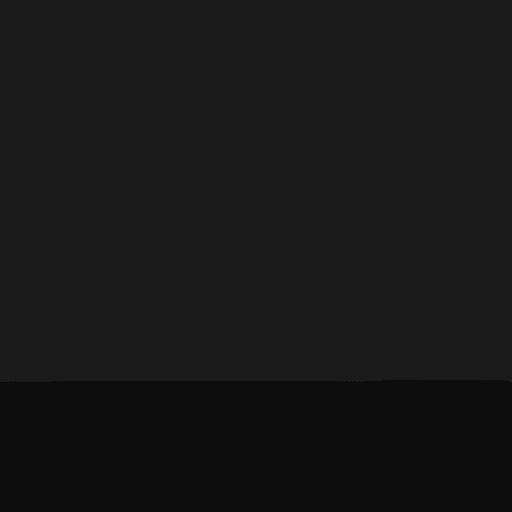

In [ ]:
segmentation = predicted_classes.cpu().numpy()


In [ ]:
Image.fromarray(segmentation.astype(np.uint8))

TypeError: ignored

In [ ]:
with open("/content/drive/MyDrive/mapillary_unzipped/config_v1.2.json", "r") as f:
  config = json.load(f)

In [ ]:
config["labels"][1]

{'color': [0, 192, 0],
 'instances': True,
 'readable': 'Ground Animal',
 'name': 'animal--ground-animal',
 'evaluate': True}

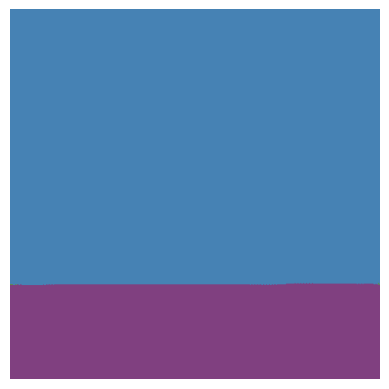

In [ ]:
rgb_image = np.zeros((512, 512, 3), dtype=np.uint8)
for index, info in enumerate(config['labels']):
    rgb_image[segmentation == index] = info['color']

# Display the image
plt.imshow(rgb_image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
array = np.array(Image.open("/content/drive/MyDrive/sample images/labels/DaEwgFJdh-5zMGQTlRBqCg.png").resize((512,512)))
array[1000:][1000:]

In [ ]:
np.array(Image.open("/content/drive/MyDrive/sample images/labels/DaEwgFJdh-5zMGQTlRBqCg.png").resize((512,512)))

In [ ]:
config["labels"][0]

In [ ]:
img = Image.open("/content/drive/MyDrive/sample images/labels/DaEwgFJdh-5zMGQTlRBqCg.png").resize((512,512))
tensor = tvt.transforms.ToTensor()(img)
torch.min(tensor)


In [ ]:
zeros = torch.zeros(48, 128, 128)
zeros.shape

In [ ]:
64-16


In [ ]:
2//2

In [ ]:
loader2 = DataLoader(dataset, batch_size= 100, num_workers= 2, shuffle= True)

In [ ]:
for i in loader2:
  print(i)

KeyboardInterrupt: ignored